In [52]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

## Defino funciones

In [114]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [115]:
from sklearn.metrics import mean_absolute_error

def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.predict(test_features)
    error = mean_absolute_error(test_labels, predict)
    score = model.score(test_features,test_labels)
    
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(score*100))
    print('Mean abs error: {:0.4f}.'.format(error))

    

In [116]:
def transformar(df,colums,func):
    for x in colums:
        df[x]=df[x].transform(lambda y: func(y))
        
columnas_para_transformar = ["metroscubiertos","metrostotales","metroscubiertostotales"]

#transformar(df1,columnas_para_transformar,np.sqrt)

## Importo dataset

In [117]:
df = pd.read_csv('../data/features.csv')

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

In [118]:
df = df.drop(columns=["direccion","descripcion","titulo"])

 ## Completo los datos faltantes

In [119]:
oneHot = ['tipodepropiedad','provincia']
binary = ['ciudad']


df_ids = df["id"]
df = df.drop(columns=["id"])

In [120]:
#Completo los numericos
df1 = imputar(df)


#Completo los categoricos
imp = SimpleImputer(strategy="constant",fill_value="-")

df1["tipodepropiedad"] = imp.fit_transform(df1[["tipodepropiedad"]])
df1["provincia"] = imp.fit_transform(df1[["provincia"]])
df1["ciudad"] = imp.fit_transform(df1[["ciudad"]])

In [121]:
df1["metroscubiertostotales"]=df1["metroscubiertos"]+df1["metrostotales"]
df1["ambientes"]=df1["banos"]+df1["habitaciones"]
df1["ambientesygarage"]=df1["banos"]+df1["habitaciones"]+df1["garages"]

 ## Genero los encodes

In [124]:
data_cols = df1._get_numeric_data().columns
baseline_data = df1[data_cols]

encoder = ce.OneHotEncoder()

encoded = encoder.fit_transform(df1[oneHot])
data = baseline_data.join(encoded)

encoder = ce.BinaryEncoder()
encoded = encoder.fit_transform(df1[binary])
data = data.join(encoded)

data.shape

(240000, 108)



## Divido data set


In [125]:
x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 107) y=(240000,)
Train shapes: X=(192000, 107) y=(192000,)
Test  shapes: X=(48000, 107)  y=(48000,)


## Modelo y entreno

In [126]:
xgb_model = XGBRegressor(n_estimators=400,max_depth=10,n_jobs=-1,objective="reg:squarederror")


In [127]:
xgb_model.fit(x_train, y_train)

/home/peter/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

## Predicciones

In [128]:
predecir(xgb_model,x_train,y_train,x_test,y_test)

Entrenamiento: 94.7381%
Testeo: 82.0012%.
Mean abs error: 536954.2369.


array([ 872890.75,  654077.75, 1363617.1 , ...,  315117.47, 4443660.  ,
       1165336.5 ], dtype=float32)

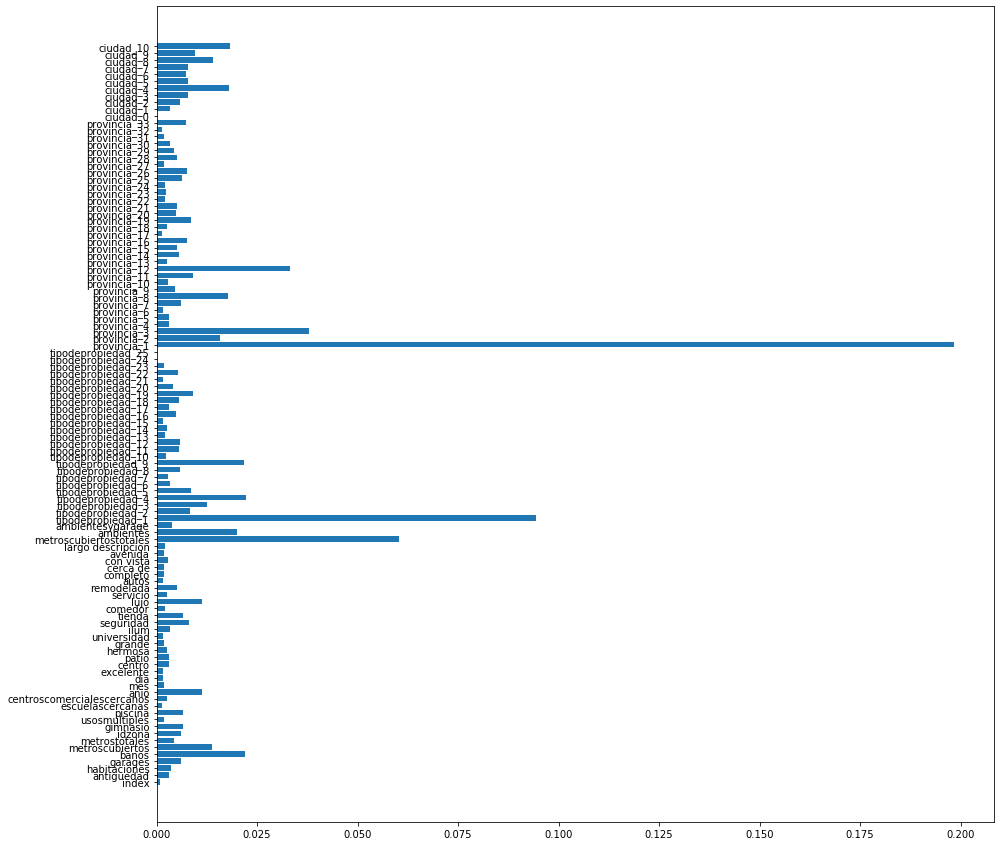

In [129]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = xgb_model.feature_importances_
ax = plt.barh(x.columns, xgb_model.feature_importances_)